Imports


In [11]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [12]:
data_path = "../udataset/health_data.csv"
df = pd.read_csv(data_path)
df = df.sort_values(by=["state", "year"])

Do PCA on data

In [13]:
features = df.drop(columns=["state", "year"])
no_components = 2
pca = PCA(n_components=no_components)
pca_features = pca.fit_transform(features)
df_pca = pd.concat([df[["state", "year"]], pd.DataFrame(pca_features)], axis=1)
df_pca

,state,year,0,1
264,Alabama,2011,-0.392001,-0.053076
265,Alabama,2012,-0.390391,0.056628
266,Alabama,2013,-0.272185,0.120431
267,Alabama,2014,-0.359922,0.074221
268,Alabama,2015,-0.254098,-0.008957
...,...,...,...,...
451,Wyoming,2018,0.174560,0.029309
452,Wyoming,2019,0.229688,-0.026006
453,Wyoming,2020,0.262339,0.106516
454,Wyoming,2021,0.377373,0.088344


In [14]:
# Drop the state column
state = df_pca['state']
features = df_pca.drop(['state'], axis=1)

start_year = df_pca['year'].min()
end_year = df_pca['year'].max()

Predict clusters

In [15]:
df_pca['cluster'] = pd.NA
num_clusters = 2
init = None
for year in range(start_year, end_year + 1):
    if init is None:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    else:
        kmeans = KMeans(n_clusters=num_clusters, init=init, random_state=0)

    year_features = features[features['year'] == year].drop(['year'], axis=1)
    cluster = kmeans.fit_predict(year_features)
    df_pca.loc[df['year'] == year, 'cluster'] = cluster
    init = kmeans.cluster_centers_

    print(f"Silhouette score for {year}: {silhouette_score(year_features, cluster)}")

df_pca

Silhouette score for 2011: 0.3780838401347271
Silhouette score for 2012: 0.40120497193268245
Silhouette score for 2013: 0.39325797097292214
Silhouette score for 2014: 0.381292351606418
Silhouette score for 2015: 0.382504909692162
Silhouette score for 2016: 0.3837695273474956
Silhouette score for 2017: 0.428926379212886
Silhouette score for 2018: 0.4468123490598423
Silhouette score for 2019: 0.43989675399956873
Silhouette score for 2020: 0.5067617279774785
Silhouette score for 2021: 0.4327437896190926
Silhouette score for 2022: 0.40244349791574124


,state,year,0,1,cluster
264,Alabama,2011,-0.392001,-0.053076,1
265,Alabama,2012,-0.390391,0.056628,1
266,Alabama,2013,-0.272185,0.120431,1
267,Alabama,2014,-0.359922,0.074221,1
268,Alabama,2015,-0.254098,-0.008957,1
...,...,...,...,...,...
451,Wyoming,2018,0.174560,0.029309,0
452,Wyoming,2019,0.229688,-0.026006,0
453,Wyoming,2020,0.262339,0.106516,0
454,Wyoming,2021,0.377373,0.088344,0


Reformat and name colums

In [16]:
# Move the cluster column to the start
cols = df_pca.columns.tolist()
df_pca = df_pca[[cols[0]] + [cols[1]] +[ cols[-1]] + cols[2:-1]]

# Rename the principal components
pca_mapping = {i: f"PC{i+1}" for i in range(no_components)}
df_pca = df_pca.rename(columns=pca_mapping)

df_pca

,state,year,cluster,PC1,PC2
264,Alabama,2011,1,-0.392001,-0.053076
265,Alabama,2012,1,-0.390391,0.056628
266,Alabama,2013,1,-0.272185,0.120431
267,Alabama,2014,1,-0.359922,0.074221
268,Alabama,2015,1,-0.254098,-0.008957
...,...,...,...,...,...
451,Wyoming,2018,0,0.174560,0.029309
452,Wyoming,2019,0,0.229688,-0.026006
453,Wyoming,2020,0,0.262339,0.106516
454,Wyoming,2021,0,0.377373,0.088344


In [17]:
print(df_pca[(df_pca['cluster'] == 1) &
    (df_pca['year'] == 2021)]['state'])

# Change 1 to healthy, 0 to less healthy
df_pca['cluster'] = df_pca['cluster'].replace({1: 'healthy', 0: 'less healthy'})

274                 Alabama
382                Arkansas
574                Colorado
418                Delaware
34     District of Columbia
298                 Florida
478                 Georgia
370                Kentucky
58                 Maryland
514                Michigan
610                Missouri
82                  Montana
334           New Hampshire
394              New Jersey
106              New Mexico
118                New York
646                  Oregon
70             Rhode Island
154                   Texas
166                    Utah
586               Wisconsin
Name: state, dtype: object


Add visualization of groups

Text(0.5, 1.0, 'KMeans Clustering of States for Health Data (All years)')

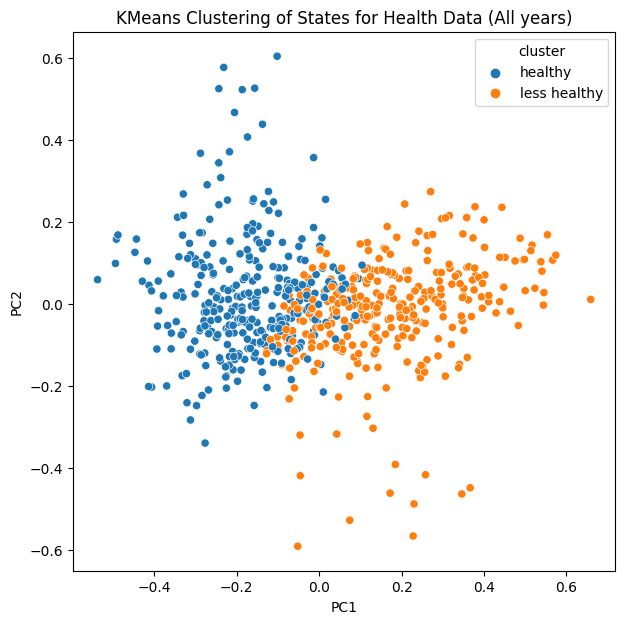

In [18]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_pca, x='PC1',
                y='PC2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of States for Health Data (All years)")

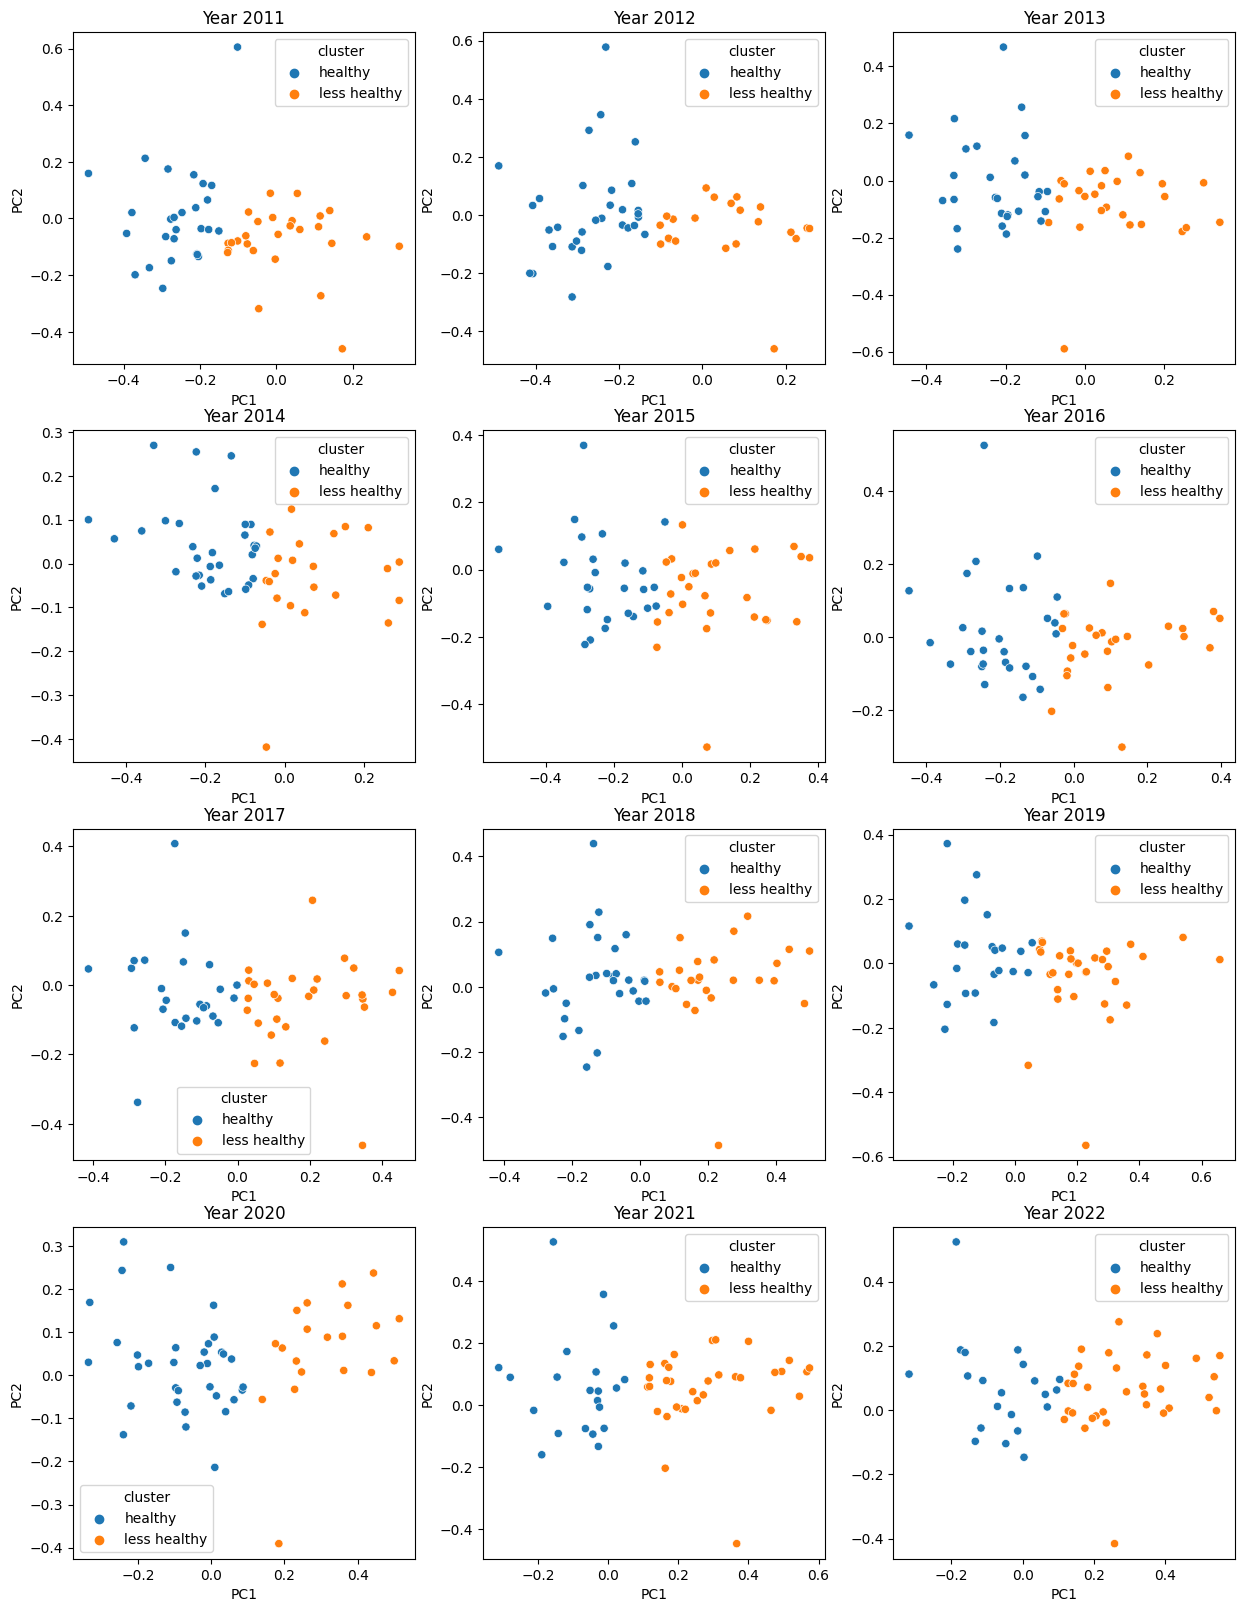

In [19]:
num_years = end_year - start_year + 1
col = 3
row = num_years // col + 1
plt.figure(figsize=(5 * col, 5 * row))

for i, year in enumerate(range(start_year, end_year + 1)):
    plt.subplot(row, col, i + 1)
    sns.scatterplot(data=df_pca[df_pca['year'] == year], x='PC1',
                    y='PC2', hue='cluster', palette='tab10')
    plt.title(f"Year {year}")

In [20]:
NEWNAME = 'health_data_clustered.csv'
df_pca.to_csv('../udataset/' + NEWNAME, index=False)